## TPU Training Example

This example demonstrates training on TPU using resources provided by current tensorflow version 2.10


*   Author: Isaac Atia-Abugbilla
*   Project: https://github.com/aymericdamien/TensorFlow-Examples/

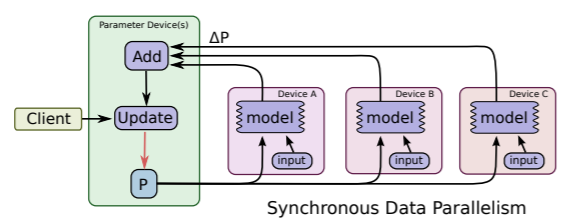

TPU training follows a similar flow as multiple GPU training except training is done using TPU (an AI accelerator application specific integrated circuit) developed by Google. 

This example uses the MNIST handwritten dataset which contains 60,000 training samples and 10,000 testing samples.

Image source: https://towardsdatascience.com/accelerated-distributed-training-with-tensorflow-on-googles-tpu-52f1fe21da33


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
# setting up TPU 

# resolve TPU cluster URL
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()

# connect to tpu cluster
tf.config.experimental_connect_to_cluster(resolver)

# initialize tpu system
tf.tpu.experimental.initialize_tpu_system(resolver)

# instantiate tpu strategy
strategy = tf.distribute.TPUStrategy(resolver)

print (f"Running on TPU cluster: {resolver.cluster_spec().as_dict()['worker']}")
print (f"Number of replicas: {strategy.num_replicas_in_sync}")

Running on TPU cluster: ['10.95.133.18:8470']
Number of replicas: 8


In [3]:
@dataclass
class C:
  # batch size to be used for each worker
  GLOBAL_BATCH_SIZE = 200
  # to parallelize the fetching and loading of data into the model
  # this ensures all parts of the TPU resourcee is in use
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  # number of classes
  NUM_CLASSES = 10
  # learning rate
  LR = 1e-3
  SHAPE = [28,28]
  # to parallelize the fetching and transforming of data
  BUFFER_SIZE = 10000

In [4]:
# download GCS version of mnist data and split to train and test
train_ds,test_ds = tfds.load(
    "mnist",
    split=['train','test'],
    as_supervised=True,
    try_gcs=True # default is False
)

In [5]:
def preprocess(image):
  image = tf.cast(image,tf.float32)
  image /= 255.
  return image

In [6]:
train_ds = (
    train_ds.map(lambda x,y: (preprocess(x),y))
    .shuffle(C.BUFFER_SIZE)
    .repeat()
    .batch(C.GLOBAL_BATCH_SIZE)
)

# transform data into form suitable for TPU training
train_dist = strategy.experimental_distribute_dataset(train_ds)

In [7]:
# define model using model subclassing
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel,self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation="relu",input_shape=[*C.SHAPE,1])
    self.max1 = tf.keras.layers.MaxPooling2D(pool_size=2,strides=2)
    self.conv2 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation="relu")
    self.max2 = tf.keras.layers.MaxPooling2D(pool_size=2,strides=2)

    self.flatten = tf.keras.layers.Flatten()
    self.classifier = tf.keras.layers.Dense(C.NUM_CLASSES)
  
  @tf.function
  def call(self,x):
    x = self.conv1(x)
    x = self.max1(x)
    x = self.conv2(x)
    x = self.max2(x)
    x = self.flatten(x)
    return self.classifier(x)

In [8]:
# build model with dummy data so we can visualize the model summary
dummy_model = MyModel()
dummy_model.build((None,28,28,1))
dummy_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  320       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  160

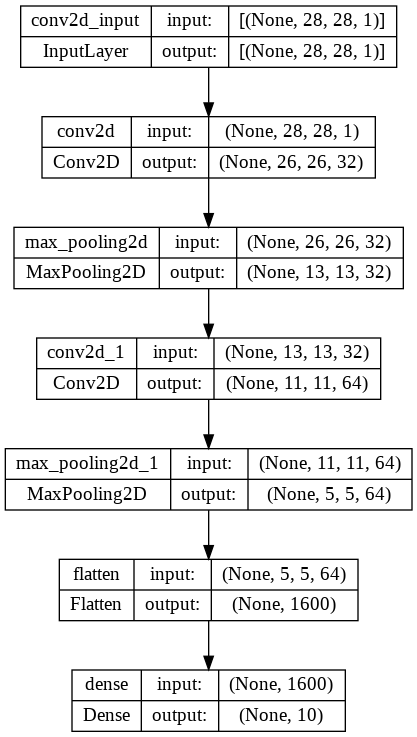

In [9]:
# plotting model for better visualization
all_list = []
for l in dummy_model.layers:
  all_list.append(l)

another_dummy = tf.keras.Sequential(all_list)
tf.keras.utils.plot_model(another_dummy,show_shapes=True,expand_nested=True)

In [10]:
# to train on tpu, model and hyperparameters should be called
# within the scope of the tpu strategy
with strategy.scope():
  model = MyModel()

  optimizer = tf.keras.optimizers.Adam(learning_rate = C.LR)

  # set reduction to NONE, this ensures the loss values
  # are not reduced using the per replica batch size
  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits = True,
      reduction = tf.keras.losses.Reduction.NONE
  )

  # compute custom averaging scheme for TPU training
  # this ensures loss is computed using the global batch size
  def compute_loss(y_true,y_pred):
    per_example_loss = loss_func(y_true,y_pred)
    return tf.nn.compute_average_loss(
        per_example_loss,
        global_batch_size=C.GLOBAL_BATCH_SIZE
    )

  # metric to calculate the accuracy of our model
  acc = tf.keras.metrics.SparseCategoricalAccuracy()

In [11]:
# the training job on each worker
# since there are 8 tpus, train_step runs on all 8
def train_step(inputs):
  x,y = inputs
  with tf.GradientTape() as tape:
    y_preds = model(x)
    loss = compute_loss(y,y_preds)

  grads = tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(grads,model.trainable_variables))
  acc.update_state(y,y_preds)
  return loss

# computes the distributed 
@tf.function
def distributed_train(dist_inputs):
  per_replica_losses = strategy.run(train_step,args=(next(dist_inputs),))
  return strategy.reduce(tf.distribute.ReduceOp.SUM,per_replica_losses,axis=None) 

In [12]:
steps_per_epoch = 60000 // C.GLOBAL_BATCH_SIZE
for e in range(1,11):
  running_loss = 0.0
  num_batches = 0
  ds = iter(train_dist)
  for i in range(steps_per_epoch):
    running_loss+=distributed_train(ds)
    num_batches+=1
  total_loss = running_loss/num_batches
  print (f"Epoch: {e}  Loss: {total_loss:.4f}\tAccuracy: {acc.result()*100:.2f}")
  acc.reset_states()

Epoch: 1  Loss: 0.3249	Accuracy: 90.94
Epoch: 2  Loss: 0.0791	Accuracy: 97.62
Epoch: 3  Loss: 0.0588	Accuracy: 98.23
Epoch: 4  Loss: 0.0476	Accuracy: 98.57
Epoch: 5  Loss: 0.0406	Accuracy: 98.76
Epoch: 6  Loss: 0.0348	Accuracy: 98.94
Epoch: 7  Loss: 0.0308	Accuracy: 99.02
Epoch: 8  Loss: 0.0276	Accuracy: 99.17
Epoch: 9  Loss: 0.0243	Accuracy: 99.29
Epoch: 10  Loss: 0.0219	Accuracy: 99.34
